# SWX1 Results Analysis D

## Python Imports

In [1]:
import numpy as np
import pandas as pd
from prettypandas import PrettyPandas
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api
from pyomo.environ import *

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import display, Markdown, HTML

%matplotlib inline
PlotWidth = 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

def backward_regression(X, y,
                           threshold_out,
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
        
    return included

def build_model(X,values,verbose=True):
    X = [sub.replace('alh', 'model.X1') for sub in X]
    X = [sub.replace('aps', 'model.X2') for sub in X]
    X = [sub.replace('aid', 'model.X3') for sub in X]
    X = [sub.replace('arw', 'model.X4') for sub in X]
    X = [sub.replace('awt', 'model.X5') for sub in X]
    X = [sub.replace(':', '*') for sub in X]
    model = str(values[0])
    i=1
    for v in X:
        model  += " + " + str(values[i]) + " * " + v
        i += 1
    if verbose:
        print(model)
    return model

## Process CSV Files

In [3]:

# importing the pandas library
import pandas as pd
  
# reading the csv file using read_csv
# storing the data frame in variable called df
df_cost = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/swx1_cost_rework.txt', sep='\t')
df_time = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/swx1_time_rework.txt', sep='\t')
  
# creating a list of column names by
# calling the .columns
list_of_columns_cost = list(df_cost.columns)
list_of_columns_time = list(df_time.columns)
  
# displaying the list of column names
print('List of Cost column names : ', 
      list_of_columns_cost)
print('List of Time column names : ', 
      list_of_columns_time)

List of Cost column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'cost']
List of Time column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'time']


In [4]:
display((Markdown("### Statistics for Cost")))
df_cost.cost.describe()

### Statistics for Cost

count    80.000000
mean      1.006563
std       0.304323
min       0.593000
25%       0.794500
50%       0.980000
75%       1.324750
max       1.387000
Name: cost, dtype: float64

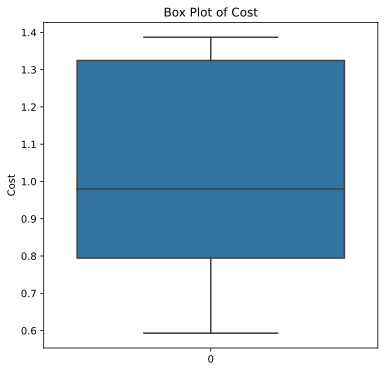

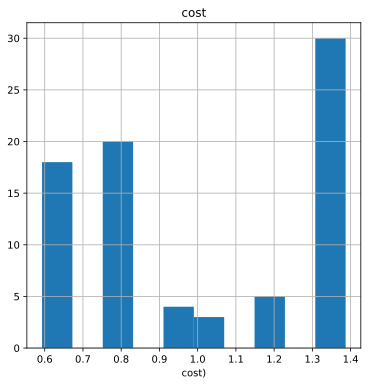

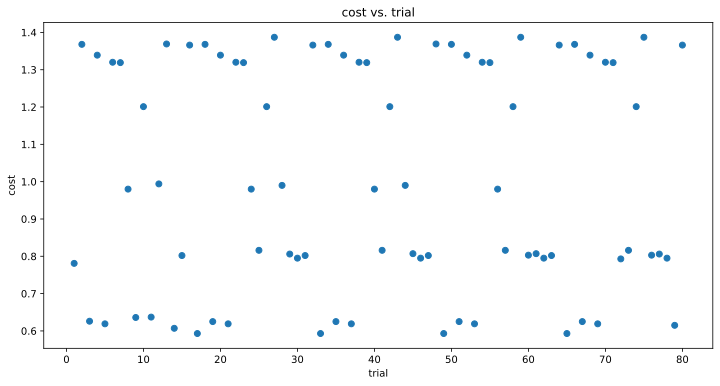

In [5]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_cost['cost'])
plt.title('Box Plot of Cost')
plt.ylabel('Cost')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_cost['cost'].hist()
plt.title('cost')
plt.xlabel('cost)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_cost['trial'], df_cost['cost'])
plt.title('cost vs. trial')
plt.xlabel('trial')
plt.ylabel('cost')
plt.show()

In [6]:
display((Markdown("### Statistics for Time")))
df_time.time.describe()

### Statistics for Time

count       80.000000
mean     11719.350000
std       2959.361294
min       7767.000000
25%       9101.000000
50%      11418.500000
75%      14610.500000
max      18254.000000
Name: time, dtype: float64

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_time['time'])
plt.title('Box Plot of Time')
plt.ylabel('Time')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_time['time'].hist()
plt.title('time')
plt.xlabel('time)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_time['trial'], df_time['time'])
plt.title('time vs. trial')
plt.xlabel('trial')
plt.ylabel('time')
plt.show()

# Cost Analysis

In [7]:
f = 'cost ~ (alh+aps+aid+arw+awt)**2'
y, X = patsy.dmatrices(f, df_cost, return_type='dataframe')
print(y[:5])
print(X[:5])

    cost
0  0.781
1  1.368
2  0.626
3  1.339
4  0.619
   Intercept   alh   aps   aid  arw  awt  alh:aps  alh:aid  alh:arw  alh:awt  \
0        1.0  0.16  60.0  0.25  0.4  0.8     9.60    0.040    0.064    0.128   
1        1.0  0.28  60.0  0.25  0.4  1.2    16.80    0.070    0.112    0.336   
2        1.0  0.16  72.0  0.25  0.4  1.2    11.52    0.040    0.064    0.192   
3        1.0  0.28  72.0  0.25  0.4  0.8    20.16    0.070    0.112    0.224   
4        1.0  0.16  60.0  0.15  0.4  1.2     9.60    0.024    0.064    0.192   

   aps:aid  aps:arw  aps:awt  aid:arw  aid:awt  arw:awt  
0     15.0     24.0     48.0     0.10     0.20     0.32  
1     15.0     24.0     72.0     0.10     0.30     0.48  
2     18.0     28.8     86.4     0.10     0.30     0.48  
3     18.0     28.8     57.6     0.10     0.20     0.32  
4      9.0     24.0     72.0     0.06     0.18     0.48  


                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     31.04
Date:                Sat, 31 Jul 2021   Prob (F-statistic):           1.26e-23
Time:                        18:50:16   Log-Likelihood:                 66.692
No. Observations:                  80   AIC:                            -101.4
Df Residuals:                      64   BIC:                            -63.27
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.7997      1.267     -5.365      0.0

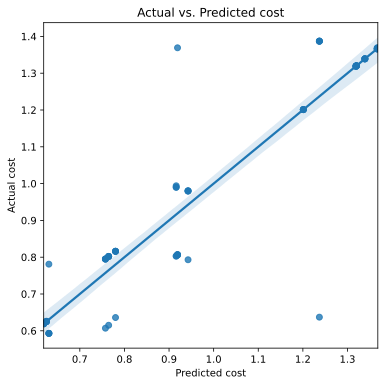

In [8]:

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

## Reduced Cost Model

In [9]:
cost_included = backward_regression(X,y,.05)
cost_included.pop(0)
print(cost_included)

Drop arw                            with p-value 0.834584
Drop alh:awt                        with p-value 0.723342
Drop aid                            with p-value 0.253413
['alh', 'aps', 'awt', 'alh:aps', 'alh:aid', 'alh:arw', 'aps:aid', 'aps:arw', 'aps:awt', 'aid:arw', 'aid:awt', 'arw:awt']


                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     39.59
Date:                Sat, 31 Jul 2021   Prob (F-statistic):           1.08e-25
Time:                        18:50:18   Log-Likelihood:                 65.790
No. Observations:                  80   AIC:                            -105.6
Df Residuals:                      67   BIC:                            -74.61
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5128      0.913     -8.232      0.0

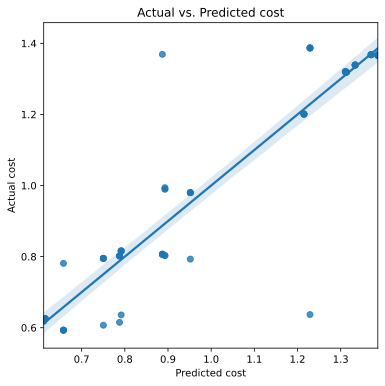

In [10]:
y = df_cost['cost']
#y = df_cost['time']
X = X[cost_included]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

In [11]:
cost_eq = build_model(cost_included,results.params,False)
print("Cost = " + cost_eq)

Cost = -7.512756311165274 + 15.594282277667375 * model.X1 + 0.1501013849966114 * model.X2 + 3.3568541135900944 * model.X5 + -0.1873958333333725 * model.X1*model.X2 + 14.97406461978116 * model.X1*model.X3 + -6.3471031138125085 * model.X1*model.X4 + -0.17544472807322514 * model.X2*model.X3 + 0.02025357325229224 * model.X2*model.X4 + -0.07640624999999765 * model.X2*model.X5 + 3.2956081485919615 * model.X3*model.X4 + 6.441435526274299 * model.X3*model.X5 + -0.6702353647414601 * model.X4*model.X5


# Time Analysis

In [12]:
f = 'time ~ (alh+aps+aid+arw+awt)**2'
y, X = patsy.dmatrices(f, df_time, return_type='dataframe')
print(y[:5])
print(X[:5])

      time
0  16946.0
1   9136.0
2  12906.0
3   9831.0
4  14617.0
   Intercept   alh   aps   aid  arw  awt  alh:aps  alh:aid  alh:arw  alh:awt  \
0        1.0  0.16  60.0  0.25  0.4  0.8     9.60    0.040    0.064    0.128   
1        1.0  0.28  60.0  0.25  0.4  1.2    16.80    0.070    0.112    0.336   
2        1.0  0.16  72.0  0.25  0.4  1.2    11.52    0.040    0.064    0.192   
3        1.0  0.28  72.0  0.25  0.4  0.8    20.16    0.070    0.112    0.224   
4        1.0  0.16  60.0  0.15  0.4  1.2     9.60    0.024    0.064    0.192   

   aps:aid  aps:arw  aps:awt  aid:arw  aid:awt  arw:awt  
0     15.0     24.0     48.0     0.10     0.20     0.32  
1     15.0     24.0     72.0     0.10     0.30     0.48  
2     18.0     28.8     86.4     0.10     0.30     0.48  
3     18.0     28.8     57.6     0.10     0.20     0.32  
4      9.0     24.0     72.0     0.06     0.18     0.48  


                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     183.9
Date:                Sat, 31 Jul 2021   Prob (F-statistic):           1.37e-46
Time:                        18:50:20   Log-Likelihood:                -600.98
No. Observations:                  80   AIC:                             1234.
Df Residuals:                      64   BIC:                             1272.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.908e+04   5339.602      7.319      0.0

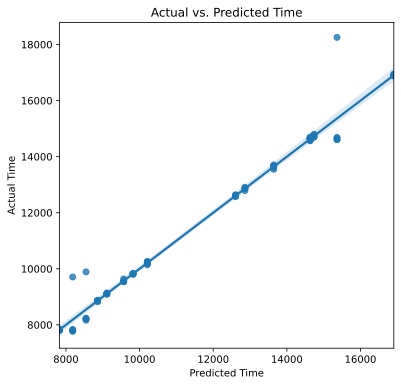

In [13]:
## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted Time')
plt.ylabel('Actual Time')
plt.title('Actual vs. Predicted Time')
plt.show()

## Time Reduced Model

In [14]:
time_included = backward_regression(X,y,.05)
time_included.pop(0)
print(time_included)

Drop aps:arw                        with p-value 0.851224
Drop aid:awt                        with p-value 0.800387
Drop alh:awt                        with p-value 0.742837
Drop awt                            with p-value 0.494038
Drop aid:arw                        with p-value 0.478725
Drop alh:arw                        with p-value 0.316918
Drop alh:aid                        with p-value 0.288586
Drop aps:aid                        with p-value 0.0661897
['alh', 'aps', 'aid', 'arw', 'alh:aps', 'aps:awt', 'arw:awt']


                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     401.6
Date:                Sat, 31 Jul 2021   Prob (F-statistic):           5.04e-55
Time:                        18:50:21   Log-Likelihood:                -604.83
No. Observations:                  80   AIC:                             1226.
Df Residuals:                      72   BIC:                             1245.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.076e+04   2315.381     17.604      0.0

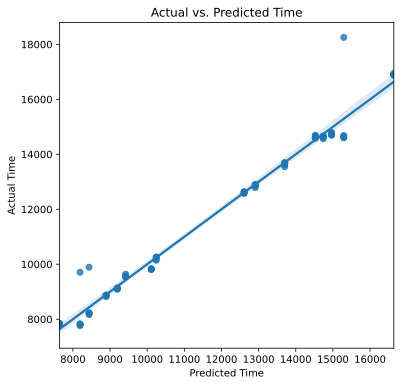

In [15]:
y = df_time['time']
X = X[time_included]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted Time')
plt.ylabel('Actual Time')
plt.title('Actual vs. Predicted Time')
plt.show()

In [16]:
time_eq = build_model(time_included,results.params,False)
print("Time = " + time_eq)

Time = 40760.716666663415 + -96855.41666666564 * model.X1 + -171.22354749789565 * model.X2 + 4256.00000000009 * model.X3 + -10004.306297709902 * model.X4 + 784.8611111111159 * model.X1*model.X2 + -118.74173027989448 * model.X2*model.X5 + 8599.556297709905 * model.X4*model.X5


## Equations

In [17]:
display(Markdown("Cost = "))
print(cost_eq)

print("------")

display(Markdown("Time = "))
print(time_eq)


Cost = 

-7.512756311165274 + 15.594282277667375 * model.X1 + 0.1501013849966114 * model.X2 + 3.3568541135900944 * model.X5 + -0.1873958333333725 * model.X1*model.X2 + 14.97406461978116 * model.X1*model.X3 + -6.3471031138125085 * model.X1*model.X4 + -0.17544472807322514 * model.X2*model.X3 + 0.02025357325229224 * model.X2*model.X4 + -0.07640624999999765 * model.X2*model.X5 + 3.2956081485919615 * model.X3*model.X4 + 6.441435526274299 * model.X3*model.X5 + -0.6702353647414601 * model.X4*model.X5
------


Time = 

40760.716666663415 + -96855.41666666564 * model.X1 + -171.22354749789565 * model.X2 + 4256.00000000009 * model.X3 + -10004.306297709902 * model.X4 + 784.8611111111159 * model.X1*model.X2 + -118.74173027989448 * model.X2*model.X5 + 8599.556297709905 * model.X4*model.X5


# Optimization

In [19]:
model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)
model.X3 = Var(within=NonNegativeReals)
model.X4 = Var(within=NonNegativeReals)
model.X5 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= .28)
model.C2 = Constraint(expr = model.X2 <= 72)
model.C3 = Constraint(expr = model.X3 <= .25)
model.C4 = Constraint(expr = model.X4 <= .8)
model.C5 = Constraint(expr = model.X5 <= 1.2)

model.C6 = Constraint(expr = model.X1 >= .16)
model.C7 = Constraint(expr = model.X2 >= 60)
model.C8 = Constraint(expr = model.X3 >= .15)
model.C9 = Constraint(expr = model.X4 >= .4)
model.C10 = Constraint(expr = model.X5 >= .8)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr = model.f1 == (-7.512756311165274 + 15.594282277667375 * model.X1 + 0.1501013849966114 * model.X2 + 3.3568541135900944 * model.X5 + -0.1873958333333725 * model.X1*model.X2 + 14.97406461978116 * model.X1*model.X3 + -6.3471031138125085 * model.X1*model.X4 + -0.17544472807322514 * model.X2*model.X3 + 0.02025357325229224 * model.X2*model.X4 + -0.07640624999999765 * model.X2*model.X5 + 3.2956081485919615 * model.X3*model.X4 + 6.441435526274299 * model.X3*model.X5 + -0.6702353647414601 * model.X4*model.X5))
model.C_f2 = Constraint(expr = model.f2 == (40760.716666663415 + -96855.41666666564 * model.X1 + -171.22354749789565 * model.X2 + 4256.00000000009 * model.X3 + -10004.306297709902 * model.X4 + 784.8611111111159 * model.X1*model.X2 + -118.74173027989448 * model.X2*model.X5 + 8599.556297709905 * model.X4*model.X5))
model.O_f1 = Objective(expr = model.f1, sense=minimize)
model.O_f2 = Objective(expr = model.f2, sense=minimize)

# max f1 separately
# install glpk solver:  sudo apt-get install glpk-utils
model.O_f2.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_min = value(model.f2)

# max f2 separately
model.O_f2.activate()
model.O_f1.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_max = value(model.f2)

# apply augmented $\epsilon$-Constraint
# max   		f1 + delta*s
# constraint 	f2 - s = e
model.O_f1.activate()
model.O_f2.deactivate()

model.del_component(model.O_f1)
model.del_component(model.O_f2)

model.e = Param(initialize=0, mutable=True)
model.delta = Param(initialize=0.00001)
model.slack = Var(within=NonNegativeReals)
model.O_f1 = Objective(expr = model.f1 + model.delta * model.slack, sense=minimize)
model.C_e = Constraint(expr = model.f2 - model.slack == model.e)

n = 100
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l, x2_l, x3_l, x4_l, x5_l = [], [], [], [], []
f1_l, f2_l = [], []
for i in steps:
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
    x3_l.append(value(model.X3))
    x4_l.append(value(model.X4))
    x5_l.append(value(model.X5))
    f1_l.append(value(model.f1))
    f2_l.append(value(model.f2))
    # print(i, value(model.X1), value(model.X2), value(model.f1), value(model.slack), value(model.f2))



( X1 , X2, X3, X4, X5 ) = ( 0.15999999183403207 , 59.999999533653316 , 0.14999999109654624 , 0.7999999847099541 , 1.2000000088828169 )
f1 = 0.5680095811532789
f2 = 14866.22869285591
( X1 , X2, X3, X4, X5 ) = ( 0.2800000099999376 , 72.00000071997307 , 0.14999999000059022 , 0.39999999000739667 , 1.2000000119995191 )
f1 = 0.9517842950707984
f2 = 7641.0830096684
